In [1]:
#Packages to be loaded. Probably there are duplicated or missing ones
import cobaya
import numpy as np
import math
from scipy.special import erf
from scipy.interpolate import CubicSpline
import camb
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate as integrate

# Cosmological parameters #

In [2]:
#Cosmological constants
c = 2.99792458E5;   HJPAS = 1/(c/100);

#Parameteres that won't be sampled
gamma = 0.545; OmegakJPAS = 0; AsJPAS = 2.09052E-9; nsJPAS = 0.9626; 

#Direct cosmological parameters of the fiducial cosmology
hJPASFid = 0.6736; OmegabJPASh2Fid = 0.02237; OmegaCDMJPASh2Fid = 0.1200; 
OmegamJPASFid = 0.3153;

#Indirect cosmological parameters of the fiducial cosmology
OmegabJPASFid = OmegabJPASh2Fid/hJPASFid**2; OmegaCDMJPASFid = OmegaCDMJPASh2Fid/hJPASFid**2;
OmegaLJPASFid = 1 - OmegamJPASFid;

#Cosmological parameters outside the fiducial cosmology
hJPAS = hJPASFid + hJPASFid/100;
OmegabJPASh2 = OmegabJPASh2Fid + OmegabJPASh2Fid/100;
OmegaCDMJPASh2 = OmegaCDMJPASh2Fid + OmegaCDMJPASh2Fid/100; 
OmegamJPAS = OmegamJPASFid + OmegamJPASFid/100;

#Indirect cosmological parameters outside the fiducial
OmegabJPAS = OmegabJPASh2/hJPAS**2; OmegaCDMJPAS = OmegaCDMJPASh2/hJPAS**2;
OmegaLJPAS = 1 - OmegamJPAS;

In [3]:
#Fiducial cosmology functions and constants
OmegamFid = 0.31417

#At z=1.7 (first bin)
EzFid = 2.6210003
XiFid = 3263.07985798
DAFid = 1208.54809555

# k and z binning #

In [4]:
#Arrays limits and steps. In h units
kminKArrayCompleto = 0.001;   kmaxKArrayCompleto = 2.4900;  pasoKArrayCompleto = 0.025;
zmin = 1.7;   zmax = 2.9;   pasoz = 0.2;

#k binning, complete and in a reduced scaleset
KArrayCompleto = np.exp(np.arange(math.log(kminKArrayCompleto), math.log(kmaxKArrayCompleto), pasoKArrayCompleto) )
KArray = KArrayCompleto[range(121,246)]

#k binning on lower and upper limits
KArrayUpper = np.zeros(len(KArray)); KArrayLower = np.zeros(len(KArray));

for i in range(0, len(KArray)-1):
    KArrayUpper[i] = KArray[i] + (KArray[i+1]-KArray[i])/2;   KArrayLower[i] = KArray[i] - (KArray[i+1]-KArray[i])/2;

KArrayUpper[-1] = KArrayUpper[-2];  KArrayLower[-1] = KArrayLower[-2];


#z binning

#Original one
zaAntes = np.arange(zmin-0.1, zmax+pasoz/2, pasoz)

#Including z=0
zaAdicional = np.array([0])

#Binning including all lower and upper z-bins limits
zaConBines = np.arange(zmin-pasoz/2, zmax+0.01+pasoz/2, pasoz/2)

#z binning
za = np.concatenate((zaAdicional,zaConBines))

#Positions of upper and lower limits of the z-bins in the za array
positions_Upper = [3, 5, 7, 9, 11, 13, 15]
positions_Lower = [1, 3, 5, 7, 9, 11, 13]

# P(k) data and densities reading #

In [5]:
# Define a class to read the simulated data specifying the path as input
def read_data(path_to_data):
    data = {}

    Simulated_pk_filename = path_to_data+'Pk_Simulated_Data_HighZ_NoFeature.dat'
    Simulated_densities = path_to_data+'Densities_HighZ.dat'

    data['pkz'] = np.zeros((len(zaAntes), len(KArray)))
    data['ndz'] = np.zeros(len(zaAntes))
  
    with open(Simulated_pk_filename) as file:
        for i in range(len(KArray)):
            line = file.readline().split()
            data['pkz'][0][i] = float(line[2])
            data['pkz'][1][i] = float(line[3])
            data['pkz'][2][i] = float(line[4])
            data['pkz'][3][i] = float(line[5])
            data['pkz'][4][i] = float(line[6])
            data['pkz'][5][i] = float(line[7])
            data['pkz'][6][i] = float(line[8])

    with open(Simulated_densities) as file:
        for i in range(len(zaAntes)):
            line = file.readline().split()
            data['ndz'][i] = float(line[1])

    return data

# Read data is converted in the dictionary 'data'
data = read_data('/Users/guillermo/Desktop/')
data.keys()

dict_keys(['pkz', 'ndz'])

# CAMB settings and results #

In [6]:
# Let's try to obtain a PPS and Pm with nodes using CAMB

#Nodes value test
nodes_log_k = [np.log(KArray[0]), np.log(KArray[-1])]
nodes_log_PPS = [2.1293593469628953, 1.8962555118848632]

#Undo the logs
nodes_k = np.exp(nodes_log_k)
nodes_PPS = np.exp(nodes_log_PPS)*1e-10

#Node interpolation. With just 2, kind always linear
func = interp1d(nodes_k, nodes_PPS,
                axis=0,  #This command interpolates among columns
                bounds_error=False,
                kind='linear',
                fill_value=(nodes_PPS[0], nodes_PPS[-1]))


#Parameter set 'pars' for CAMB, with its cosmology, a modified PPS and a P(m) including the nodes
from camb import model

pars = camb.CAMBparams()
pars.InitPower = camb.initialpower.SplinedInitialPower()
pars.set_cosmology(H0=hJPAS*100, ombh2=OmegabJPASh2, omch2=OmegaCDMJPASh2, mnu=0.0, omk=OmegakJPAS, tau=0.06)
pars.InitPower.set_scalar_log_regular(KArrayCompleto[0], KArrayCompleto[-1], func(KArrayCompleto))
pars.set_matter_power(redshifts=za, kmax=KArrayCompleto[-1])
pars.NonLinear = model.NonLinear_none

Note: redshifts have been re-sorted (earliest first)


In [7]:
#CAMB matter power spectrum Pm(k) with the nodes methodology included.

results = camb.get_results(pars) #Resultados de CAMB
kh, z, pk = results.get_matter_power_spectrum(minkh=KArrayCompleto[0], maxkh=KArrayCompleto[-1], npoints = len(KArrayCompleto))

# Classes to interface with Cobaya #

In [8]:
#If previous is OK, now the classes to interface with Cobaya are created.

#A cobaya theory NodesInPrimordialPk and a cobaya external likelihood Pklike classes are created

#Needed packages
from cobaya.theory import Theory
from cobaya.likelihood import Likelihood

In [9]:
#Class of the theory, with the PPS modification including the nodes
class NodesInPrimordialPk(Theory):

    def initialize(self): #Initialize self with the k-array
        self.ks = KArray

    #It seems that in here we allocate the values of the parameters to be sampled and definme their names
    def calculate(self, state, want_derived=True, **params_values_dict):
        
        pivot_scalar = 0.05   #k pivot value
        
        nodes_k = [params_values_dict['k1'], params_values_dict['k2']] 
        nodes_PPS = [params_values_dict['P1'], params_values_dict['P2']] 

        #I guess I can fixed the k nodes for the N=2 here
        #nodes_k = [np.log(KArray[0]), np.log(KArray[-1])]
        
        #nodes_k and nodes_PPS are interpolated
        Pk_func = interp1d(nodes_k, nodes_PPS,
                axis=0,  # interpolate along columns
                bounds_error=False,
                kind='linear',
                fill_value=(nodes_PPS[0], nodes_PPS[-1]))
        
        #The PPS(k) is evaluated at our array of k
        state['primordial_scalar_pk'] = {'kmin': KArray[0], 'kmax': KArray[-1],
                                         'Pk': Pk_func(KArray), 'log_regular': True}

    #To be able to evaluate the PPS?
    def get_primordial_scalar_pk(self):
        return self.current_state['primordial_scalar_pk']
   
    #Function that returns the nodes parameters values
    def get_can_support_params(self):
        return ['k1', 'k2', 'P1', 'P2']


In [10]:
#Class incorporating the monopole and the likelihood. 


class Pklike(Likelihood): #Class is defined
    
    def initialize(self):  

        #Path in wich the data are. We call read_data with this path.
        self.data = read_data('/Users/guillermo/Desktop/')

        #Grid of z to be employed
        self.z_win = zaAntes
        self.z_winCompleto = za
        self.ks = KArray

    
    def get_requirements(self): #¿Por qué es necesario tener requisitos? ¿No puedo usar las funciones sin esto?
        
        return {'omegam': None,                 
                'Pk_interpolator': {'z': self.z_winCompleto, 'k_max': 10, 'nonlinear': False, 'vars_pairs': ([['delta_tot', 'delta_tot']])},
                'comoving_radial_distance': {'z': self.z_winCompleto},
                'angular_diameter_distance': {'z': self.z_winCompleto},
                'Hubble': {'z': self.z_winCompleto, 'units': 'km/s/Mpc'},
                'sigma8_z': {'z': self.z_winCompleto},
                 #'fsigma8': {'z': self.z_win, 'units': None},
                'CAMBdata': None}

   
    #Definition of the monopole
    
    def monopole(self, **params_dic):

        results = self.provider.get_CAMBdata()   #CAMB results in results
             
        # Esta parte quizás la puedo omitir
        ks = KArray
        pps = results.Params.scalar_power(ks)       
        
        # All functions and variables to compute the Kaiser model
        Omegam = self.provider.get_param('omegam')  
        Ez = np.sqrt( Omegam*(1+self.z_winCompleto)**3+(1-Omegam) ); 
        H = HJPAS * Ez
        f = (Omegam*(1+self.z_winCompleto)**3*1/(Ez**2))**gamma
        sigma8z0 = self.provider.get_sigma8_z(self.z_winCompleto[0])
        DeReves = self.provider.get_sigma8_z(self.z_winCompleto)/sigma8z0
        De = DeReves[::-1]
        
        def bJPAS(z):
          return 0.53+0.289*(1+z)**2
            
        A = De*bJPAS(za)*sigma8z0
        R = De*f*sigma8z0

        # Photometric factor
        DeltazJPAS = 0.00364236313918151
        sigmar = DeltazJPAS*(1+self.z_winCompleto)/H


        # This is the matter power spectrum interpolator:
        pk = self.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False)    #P matter is obtained here
        
        print(ks,self.z_winCompleto,pk.P(ks,self.z_winCompleto[2]),'pruebaprint')
        #print(pk.P(ks,self.z_winCompleto[2]), 'carlitos')
        #print(pk.P(ks,self.z_winCompleto[2]), 'carlitos')
        
        #pk_delta = pk.P(ks,self.z_winCompleto)         # pk_delta is Pk evaluated at ks and zs
        #print(ks,'carlitos')
        #ca = self.provider.get_Pk_interpolator(self.z_winCompleto, ks[-1], nonlinear=False)
        plt.plot(ks, pps, label='Pk_interpolator') 
        plt.xlabel('k')
        plt.ylabel('Pm')
        plt.savefig('Pm_interpolator.png') 
        plt.show() 

        
        # Fingers of God effect
        sigmap = (   1/(6*np.pi**2)*(De[2]/1)**2*integrate.quad(lambda k: pk.P(k,self.z_winCompleto[2]) , ks[0], ks[-1])[0]  )**0.5


        
        def FFog(mu,k):
            return 1/(1+(f[2]*k*mu*sigmap)**2)

        
        # AP effect
        Xi = self.provider.get_comoving_radial_distance(self.z_winCompleto)*hJPAS;
        DA = Xi/(1+self.z_winCompleto);
        
        FactorAP = DAFid**2*Ez[2]/( DA[2]**2*EzFid )

        def Q(mu):
            return ((Ez[2]**2*Xi[2]**2*mu**2-EzFid**2*XiFid**2*(mu**2-1))**0.5/(EzFid*Xi[2]))
 
        def muObs(mu):
            return mu*Ez[2]/(EzFid*Q(mu))
           
        def kObs(mu,k):
            return Q(mu)*k 

        #P galaxy
        def Pg(mu,k):
            return FactorAP*FFog(muObs(mu),kObs(mu,k))*(A[2]+R[2]*muObs(mu)**2)**2 * pk.P(kObs(mu,k),self.z_winCompleto[2])/sigma8z0**2 *np.exp(-(k*mu*sigmar[2])**2)

        #Trapezoid rule with 2000 steps for computing the Pmonopole(k)
        def Pgmonopole(k):
            mu = np.arange(-1, 1, 1/1000)
            return 1/2 * integrate.trapz(Pg(mu, k), mu)
            
        PgmonopoleValores = np.zeros(len(self.ks))
        
        for i in range(0, len(ks)):
             PgmonopoleValores[i] = Pgmonopole(ks[i])

        #Covariance
        
        #Densities are red from self.data['ndz].

        #Definition of the volume (requires angular distance and za lower/upper bining)
        #Area of the sky
        fsky = 0.2575;

        #Angular distance for z upper and lower bins:

        XiZaLower = self.provider.get_comoving_radial_distance(self.z_winCompleto[positions_Lower])*hJPAS
        XiZaUpper = self.provider.get_comoving_radial_distance(self.z_winCompleto[positions_Upper])*hJPAS

        
        #Definition of the volume between redshift bins
        Vol = 4*np.pi*fsky/3*(XiZaUpper**3-XiZaLower**3)

        #Number of modes. It depends of ksup and kinf corresponding to kupper y klower
        def Nk(ksup,kinf):
            return Vol[0] * (4*np.pi/3*(ksup**3-kinf**3))/((2*np.pi)**3)

        #Nk evaluated for each of our k-bins
        NkEvaluado = np.zeros(len(ks))
        for i in range(0, len(ks)):
            NkEvaluado[i] = Nk(KArrayUpper[i],KArrayLower[i])

        #Covariance Cov definition
        def Cov(k,k1,k2):
            return 2 * (Pgmonopole(k) + 1/self.data['ndz'][0])**2 / Nk(k1,k2)

        #Cov evaluated at our k array
        CovEvaluado = 2 *(PgmonopoleValores + 1/self.data['ndz'][0])**2 / NkEvaluado

        #We return the value of the monopole at our k-array

        
        return PgmonopoleValores, CovEvaluado


    #Likelihood calculation
    
    def logp(self, **params_values):       
        
        Pk = self.monopole(**params_values)[0]    #Del anterior código. ¿Debo llamar al monopolo así o con PgmonopoleValores[i]?
        
        #For allocating the monopole values and cov valued

        PMonopoleBineado = np.zeros((7, len(self.ks)))
        CovBineado = np.zeros((7, len(self.ks)))

        
        PMonopoleBineado[0, :len(self.ks)],CovBineado[0, :len(self.ks)] = self.monopole(**params_values)
        

        #Likelihood is constructed, with j being the z-array value, and i the k-array value.
        #Now we work with just j=0, corresponding to the first z-bin 1.7

        #Likelihood similar to an chi^2. Factor of log cov?
        def lnlikeSinSumar(j,i):
            
            return (self.monopole(**params_values)[0][i]-data['pkz'][0][i])**2 * 1/CovBineado[j][i] + np.log(CovBineado[j][i])
            # return(PgBineado[j][i]-data['pkz'][0][i])**2 * 1/CovBineado[j][i] + np.log(CovBineado[j][i])

            #Indices in which we sum over the likelihood values. We use all of them
            IndicesLikelihood = np.arange(0,len(ks),1)

            #Final likelihood value
            lnlike = np.sum(lnlikeSinSumar(0,IndicesLikelihood))


            return lnlike


In [11]:
# Input given to Cobaya.

# We define the dictionary 'info' including all our information, including the likelihood, theory (with the monopole)
# and the priors

info = {'debug': True,                        #Allow to debug
        'likelihood': {'jpass': Pklike},      #Link likelihood (nombre jpass) with the previously defined class?
        'theory': {'camb': {"external_primordial_pk": True},
                   'my_pk': NodesInPrimordialPk},      #Theory class, with the name "my_pk".
       'params': {
           
        # Fixed cosmological parameters
        'tau': 0.06, 'mnu': 0.00, 'nnu': 3.046, 'k1': 0.02, 'k2': 0.45,
        #'P1': 2.2e-9, 'P2': 2.0e-9, 'ombh2': OmegabJPASh2Fid, 'omch2': OmegaCDMJPASFid, 'H0': hJPASFid*100}
           
        # Parameters of the nodes, with flat priors
        'P1': {'prior': {'min': 1e-10, 'max': 5.6e-9}, 'latex': 'P_1'},
        'P2': {'prior': {'min': 1e-10, 'max': 5.6e-9}, 'latex': 'P_2'},
           
        # Cosmological parameters to be sampled. Loc y scale are the mean value and the st deviation in a guassian prior
        'ombh2': {'prior': {'dist': 'norm', 'loc': OmegabJPASh2Fid, 'scale': 0.00015}, 'latex': 'Omega_bh^2'},
        'omch2': {'prior': {'dist': 'norm', 'loc': OmegaCDMJPASh2Fid, 'scale': 0.0012}, 'latex': 'Omega_ch^2'},
        'H0': {'prior': {'dist': 'norm', 'loc': hJPASFid*100, 'scale': 0.54}, 'latex': 'H_0'}}
       
        #'sampler': {
            #'evaluate': {
                #'override': {
                   #'P1': 2.2e-9, 'P2': 2.0e-9, 'ombh2': OmegabJPASh2Fid, 'omch2': OmegaCDMJPASFid, 'H0': hJPASFid*100}}}
       }

/Users/guillermo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


 2024-01-23 10:04:15,241 [model] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: false
    extra_args: null
    ignore_obsolete: false
    use_renames: false
    external_primordial_pk: true
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
  my_pk:
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.NodesInPrimordialPk ''
likelihood:
  jpass:
    type: []
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.Pklike ''
params:
  tau:
    value: 0.06
  mnu:
    value: 0.0
  nnu:
    value: 3.046
  k1:
    value: 0.02
  k2:
    value: 0.45
  P1:
    prior:
      min: 1.0e-10
      max: 5.6e-09
    latex: P_1
  P2:
    prior:
      min: 1.0e-10
      max: 5.6e-09
    latex: P_2
  ombh2:
    prior:
      dist: norm
      loc: 0

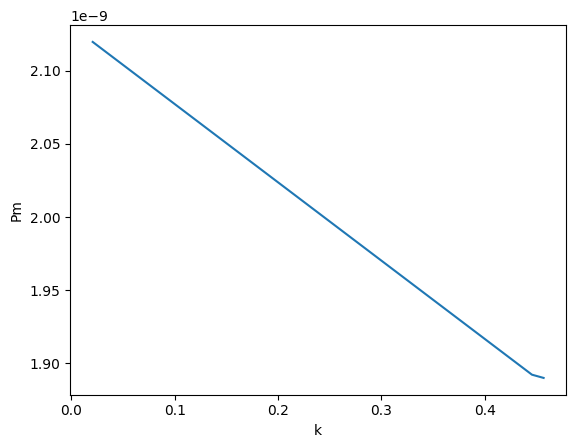

[0.020594   0.02111534 0.02164988 0.02219795 0.0227599  0.02333606
 0.02392682 0.02453253 0.02515357 0.02579034 0.02644323 0.02711264
 0.027799   0.02850273 0.02922428 0.0299641  0.03072264 0.03150039
 0.03229783 0.03311545 0.03395377 0.03481332 0.03569462 0.03659823
 0.03752472 0.03847467 0.03944866 0.0404473  0.04147123 0.04252108
 0.04359751 0.04470118 0.0458328  0.04699306 0.0481827  0.04940245
 0.05065308 0.05193537 0.05325012 0.05459815 0.05598031 0.05739746
 0.05885048 0.06034029 0.06186781 0.063434   0.06503984 0.06668633
 0.0683745  0.07010541 0.07188014 0.07369979 0.07556551 0.07747846
 0.07943984 0.08145087 0.08351281 0.08562694 0.0877946  0.09001713
 0.09229593 0.09463241 0.09702804 0.09948432 0.10200277 0.10458499
 0.10723257 0.10994717 0.1127305  0.11558428 0.11851031 0.12151042
 0.12458647 0.12774039 0.13097415 0.13428978 0.13768934 0.14117496
 0.14474883 0.14841316 0.15217026 0.15602246 0.15997219 0.16402191
 0.16817414 0.17243149 0.17679661 0.18127224 0.18586117 0.1905

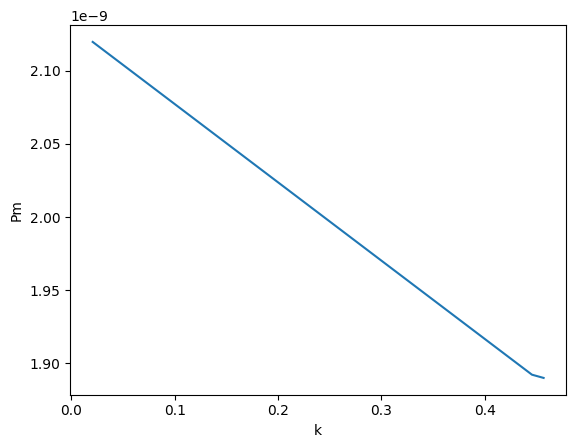

 2024-01-23 10:04:19,601 [jpass] Computed log-likelihood = None
 2024-01-23 10:04:19,602 [model] Computed derived parameters: {}


In [12]:
# Let's reproduce the same matter power spectrum as the one by single camb through the cobaya interface

from cobaya.model import get_model     
model = get_model(info)          #A model is constructed with the 'info' dictionary

fixed_values = {'tau': 0.06, 'mnu': 0.00, 'nnu': 3.046, 'k1': 0.02, 'k2': 0.45,
    'P1': 2.12e-9, 'P2': 1.89e-9, 'H0': 67.38, 'ombh2': OmegabJPASh2Fid,
    'omch2': OmegaCDMJPASh2Fid}

model.logposterior(fixed_values)          #Esto?

camb_results = model.provider.get_CAMBdata();  #Esto?

#pk = model.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False) #Y esto?
